In [1]:
import matplotlib.pyplot as plt
import numpy as np

import yt

In [10]:
def doit(ds):
    # a FFT operates on uniformly gridded data.  We'll use the yt
    # covering grid for this.

    max_level = ds.index.max_level

    ref = int(np.prod(ds.ref_factors[0:max_level]))

    low = ds.domain_left_edge
    dims = ds.domain_dimensions * ref

    nx, ny, nz = dims

    nindex_rho = 1.0 / 3.0 - 1.

    Kk = np.zeros((nx // 2 + 1, ny // 2 + 1, nz // 2 + 1))

    for vel in [("WVX")]:
        Kk += 0.5 * fft_comp(
            ds, ("RHOSTAR"), vel, nindex_rho, max_level, low, dims
        )

    # wavenumbers
    L = (ds.domain_right_edge - ds.domain_left_edge).d

    kx = np.fft.rfftfreq(nx) * nx / L[0]
    ky = np.fft.rfftfreq(ny) * ny / L[1]
    kz = np.fft.rfftfreq(nz) * nz / L[2]

    # physical limits to the wavenumbers
    kmin = np.min(1.0 / L)
    kmax = np.min(0.5 * dims / L)

    kbins = np.arange(kmin, kmax, kmin)
    N = len(kbins)

    # bin the Fourier KE into radial kbins
    kx3d, ky3d, kz3d = np.meshgrid(kx, ky, kz, indexing="ij")
    k = np.sqrt(kx3d**2 + ky3d**2 + kz3d**2)

    whichbin = np.digitize(k.flat, kbins)
    ncount = np.bincount(whichbin)

    E_spectrum = np.zeros(len(ncount) - 1)

    for n in range(1, len(ncount)):
        E_spectrum[n - 1] = np.sum(Kk.flat[whichbin == n])

    k = 0.5 * (kbins[0 : N - 1] + kbins[1:N])
    E_spectrum = E_spectrum[1:N]

    index = np.argmax(E_spectrum)
    kmax = k[index]
    Emax = E_spectrum[index]

    plt.loglog(k, E_spectrum)
    plt.loglog(k, Emax * (k / kmax) ** (-5.0 / 3.0), ls=":", color="0.5")

    plt.xlabel(r"$k$")
    plt.ylabel(r"$E(k)dk$")



def fft_comp(ds, irho, iu, nindex_rho, level, low, delta):
    cube = ds.covering_grid(level, left_edge=low, dims=delta, fields=[irho, iu])

    rho = cube[irho].d
    u = cube[iu].d

    nx, ny, nz = rho.shape

    # do the FFTs -- note that since our data is real, there will be
    # too much information here.  fftn puts the positive freq terms in
    # the first half of the axes -- that's what we keep.  Our
    # normalization has an '8' to account for this clipping to one
    # octant.
    ru = np.fft.fftn(rho**nindex_rho * u)[
        0 : nx // 2 + 1, 0 : ny // 2 + 1, 0 : nz // 2 + 1
    ]
    ru = 8.0 * ru / (nx * ny * nz)

    return np.abs(ru) ** 2

yt : [INFO     ] 2023-12-30 21:22:34,499 Parameters: current_time              = 2030.078125
yt : [INFO     ] 2023-12-30 21:22:34,501 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2023-12-30 21:22:34,503 Parameters: domain_left_edge          = [-100. -100.    0.]
yt : [INFO     ] 2023-12-30 21:22:34,504 Parameters: domain_right_edge         = [100. 100.   1.]


[512 512   1]


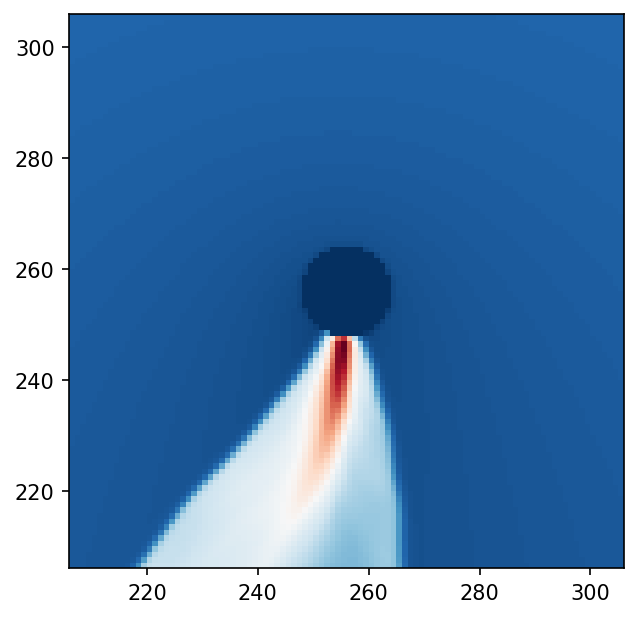

In [37]:
ds = yt.load("./plt20788")

max_level = ds.index.max_level

ref = int(np.prod(ds.ref_factors[0:max_level]))
low = ds.domain_left_edge
dims = ds.domain_dimensions * ref
nx, ny, nz = dims
print(dims)

cube = ds.covering_grid(max_level, left_edge=low, dims=dims, fields=[("RHOSTAR"), ("WVX"),("RHOB")])

rho = cube[("RHOSTAR")].d
rho = cube[("RHOB")].d
# rho = cube[irho].d
# u = cube[iu].d
nx, ny, nz = rho.shape
boxl=50

fig, ax = plt.subplots(dpi=150)

plt.pcolormesh(rho[:,:,0], cmap="RdBu_r")
plt.xlim(nx//2-boxl, nx//2+boxl)
plt.ylim(ny//2-boxl, ny//2+boxl)
ax.set_aspect('equal')


yt : [INFO     ] 2023-12-29 22:37:27,944 Parameters: current_time              = 2030.078125
yt : [INFO     ] 2023-12-29 22:37:27,946 Parameters: domain_dimensions         = [512 512   1]


yt : [INFO     ] 2023-12-29 22:37:27,947 Parameters: domain_left_edge          = [-100. -100.    0.]
yt : [INFO     ] 2023-12-29 22:37:27,948 Parameters: domain_right_edge         = [100. 100.   1.]


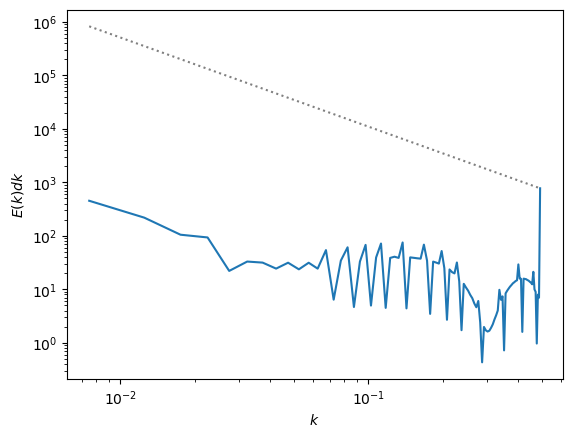

In [11]:
data_fig = "./plt20788"

ds = yt.load(data_fig)
doit(ds)

plt.savefig("bbh.png")

In [3]:
import numpy as np
a = (1.25664/(4.0*np.pi))
a

0.10000023384349968